In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [3]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)


# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw);


def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 
    


def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
    
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)


In [4]:
new_df = pd.read_csv('../input/nlp-getting-started/train.csv')
final_test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [5]:
new_df['keyword'] = new_df['keyword'].fillna('unknown')
new_df['location'] = new_df['location'].fillna('unknown')


new_df = new_df[['target', 'location', 'text', 'keyword']]
final_test = final_test[['location', 'text', 'keyword']]



new_df['text'] = new_df['text'].apply(remove_punctuation)
new_df['text'] = new_df['text'].apply(stopwords)
new_df['text'] = new_df['text'].apply(stemming)
new_df['text'] = new_df['text'].apply(remove_URL)
new_df['text'] = new_df['text'].apply(remove_html)
new_df['text'] = new_df['text'].apply(remove_emoji)
new_df['text'] = new_df['text'].apply(remove_punct)



final_test['text'] = final_test['text'].apply(remove_punctuation)
final_test['text'] = final_test['text'].apply(stopwords)
final_test['text'] = final_test['text'].apply(stemming)
final_test['text'] = final_test['text'].apply(remove_URL)
final_test['text'] = final_test['text'].apply(remove_html)
final_test['text'] = final_test['text'].apply(remove_emoji)
final_test['text'] = final_test['text'].apply(remove_punct)


In [6]:
new_df.head()

,target,location,text,keyword
0,1,unknown,deed reason earthquak may allah forgiv us,unknown
1,1,unknown,forest fire near la rong sask canada,unknown
2,1,unknown,resid ask shelter place notifi offic evacu she...,unknown
3,1,unknown,13000 peopl receiv wildfir evacu order california,unknown
4,1,unknown,got sent photo rubi alaska smoke wildfir pour ...,unknown


In [7]:
from bs4 import BeautifulSoup

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

new_df['text'] = new_df['text'].apply(cleanText)
new_df['keyword'] = new_df['keyword'].apply(cleanText)

final_test['text'] = final_test['text'].apply(cleanText)
final_test['keyword'] = final_test['keyword'].fillna('unknown')
final_test['keyword'] = final_test['keyword'].apply(cleanText)


In [8]:
train, test = train_test_split(new_df, test_size=0.2, random_state=42)


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [10]:
from collections import Counter

def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [11]:
text_values = train["text"]

counter = counter_word(text_values)

In [12]:
# The maximum number of words to be used. (most frequent)

vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint.
max_length = 20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12

In [13]:

training_sentences = new_df.text[0:training_size]
training_labels = new_df.target[0:training_size]

testing_sentences = new_df.text[training_size:]
testing_labels = new_df.target[training_size:]

In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [15]:
word_index = tokenizer.word_index

In [16]:
# Lets see the first 10 elements
print("THe first word Index are: ")
for x in list(word_index)[0:15]:
    print (" {},  {} ".format(x,  word_index[x]))

THe first word Index are: 
 <XXX>,  1 
 url,  2 
 like,  3 
 fire,  4 
 get,  5 
 amp,  6 
 im,  7 
 via,  8 
 new,  9 
 burn,  10 
 peopl,  11 
 go,  12 
 flood,  13 
 emerg,  14 
 one,  15 


In [17]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [18]:
print(train.text[1])
print(training_sequences[1])

forest fire near la rong sask canada
[116, 4, 120, 568, 4828, 4829, 1179]


In [19]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [20]:
def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [21]:
decode(training_sequences[1])

'forest fire near la rong sask canada'

In [22]:
print(train.text[1])
print(training_sequences[1])

forest fire near la rong sask canada
[116, 4, 120, 568, 4828, 4829, 1179]


In [23]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [24]:
# Model Definition with LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(14, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # remember this is a binary clasification
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            414016    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 14)                1806      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 465,501
Trainable params: 465,501
Non-trainable params: 0
_________________________________________________________________


In [26]:
import time
start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

final_time = (time.time()- start_time)/60
print(f'The time in minutos: {final_time}')

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 8s 1ms/sample - loss: 0.5426 - accuracy: 0.7131 - val_loss: 0.4608 - val_accuracy: 0.7794
Epoch 2/10
6090/6090 [==============================] - 4s 729us/sample - loss: 0.3070 - accuracy: 0.8767 - val_loss: 0.4831 - val_accuracy: 0.7807
Epoch 3/10
6090/6090 [==============================] - 4s 669us/sample - loss: 0.1765 - accuracy: 0.9369 - val_loss: 0.6555 - val_accuracy: 0.7288
Epoch 4/10
6090/6090 [==============================] - 4s 683us/sample - loss: 0.1174 - accuracy: 0.9616 - val_loss: 0.7225 - val_accuracy: 0.7249
Epoch 5/10
6090/6090 [==============================] - 4s 650us/sample - loss: 0.0910 - accuracy: 0.9721 - val_loss: 0.8294 - val_accuracy: 0.7091
Epoch 6/10
6090/6090 [==============================] - 4s 661us/sample - loss: 0.0799 - accuracy: 0.9747 - val_loss: 0.6832 - val_accuracy: 0.7163
Epoch 7/10
6090/6090 [==============================] - 4s 649us/s

In [27]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.542583,0.713136,0.460793,0.779383
1,0.306984,0.876683,0.483089,0.780696
2,0.176550,0.936946,0.655490,0.728825
3,0.117422,0.961576,0.722544,0.724885
4,0.090992,0.972085,0.829365,0.709127


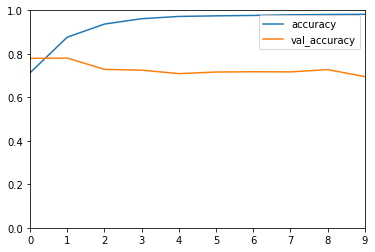

In [28]:
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1]);

In [29]:
predictions = model.predict_classes(testing_padded)

# Test Data

In [40]:
testing_sequences2 = tokenizer.texts_to_sequences(final_test.text)
testing_padded2 = pad_sequences(testing_sequences2, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [41]:
predictions = model.predict(testing_padded2)

In [42]:
predictions.shape

(3263, 1)

In [43]:
sub_sample = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submit = sub_sample.copy()
submit.target = np.where(predictions > 0.5,1,0)



In [44]:
sub_sample.shape

(3263, 2)

In [ ]:
submit.to_csv('submit_lstm.csv',index=False)